# Initial params

In [8]:
rollingWindow = 20
ticker = 'FB'
start = datetime(2019, 1, 1)
end = datetime(2019, 12, 31)

# Loading intraday data

In [9]:
path = f'../data/intraday/{ticker}_intraday.{start.strftime("%Y-%m-%d")}_{end.strftime("%Y-%m-%d")}.pkl'
print(f'Target file path {path}')
if os.path.exists(path):
    print(f"Loaded intraday data from {path}")
    intraday = pd.read_pickle(path)
else:
    conf = input("Confirm loading from IEX? [Y,N] ")
    if conf.strip().upper()=='Y':
        os.environ['IEX_TOKEN'] = 'pk_70373470bd234060b26da8e689b8c47f' # insert your API key
        dfs = []

        for dt in pd.date_range(start, end, freq='B'):
            print(f"Loading intraday data for {dt}")
            df = get_historical_intraday(ticker, dt, output_format='pandas')
            if len(df)>0:
                df = df.loc[:,['date','marketOpen','marketClose','marketVolume']]
                df.rename(columns={'marketOpen':'open', 'marketClose':'close', 'marketVolume':'volume'}, inplace=True)
                dfs.append(df)

        intraday = pd.concat(dfs)
        intraday.index = pd.to_datetime(intraday.index)
        intraday.date = pd.to_datetime(intraday.date)
        print(f"Saved intraday data to {path}")
        intraday.to_pickle(path)
    else:
        print("Nothing to do")
        assert(False)
    
intraday.head()

Target file path ../data/intraday/FB_intraday.2019-01-01_2019-12-31.pkl
Loaded intraday data from ../data/intraday/FB_intraday.2019-01-01_2019-12-31.pkl


,date,open,close,volume
2019-04-01 09:30:00,2019-04-01,167.830,167.870,318566
2019-04-01 09:31:00,2019-04-01,167.935,168.250,68135
2019-04-01 09:32:00,2019-04-01,168.270,168.270,126594
2019-04-01 09:33:00,2019-04-01,168.265,168.035,48753
2019-04-01 09:34:00,2019-04-01,168.030,168.140,71750


Prepare daily aggregate and geometric moving average

In [250]:
daily = intraday.groupby('date').agg({'open': 'first', 'close': 'last', 'volume': 'sum'})
daily.index = pd.to_datetime(daily.index)
daily['gmav'] = daily.volume.rolling(rollingWindow).agg(gmean).transform(np.ceil)
daily.tail()

,open,close,volume,gmav
date,,,,
2019-12-24,206.300,205.15,3228990,8304072.0
2019-12-26,205.566,207.79,5780968,8288985.0
2019-12-27,208.670,208.10,6958411,8154020.0
2019-12-30,207.860,204.41,7428730,8258235.0
2019-12-31,203.995,205.09,5792282,8124318.0


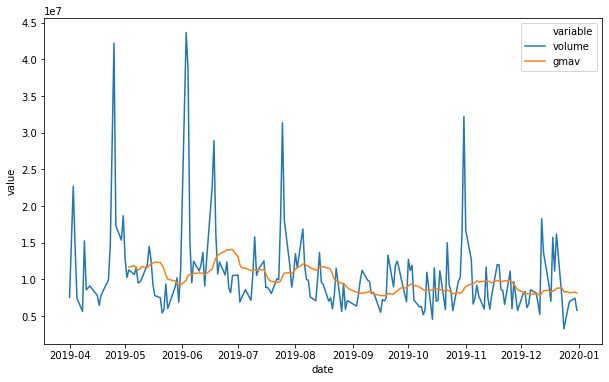

In [251]:
sns.lineplot(x='date', y='value', hue='variable', data=daily.loc[:,['volume','gmav']].reset_index().melt(id_vars=['date']))
plt.show()

# Fit lognorm dist
For some reason scipy fails to accurately fit lognorm to volume, so fitting norm to log volume

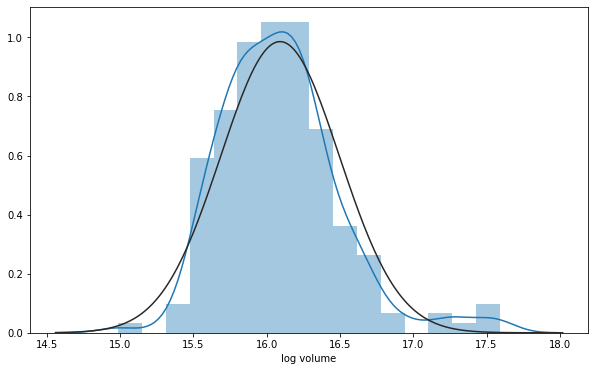

In [252]:
sns.distplot(np.log(daily.volume), fit=stats.norm, axlabel='log volume')
plt.show()

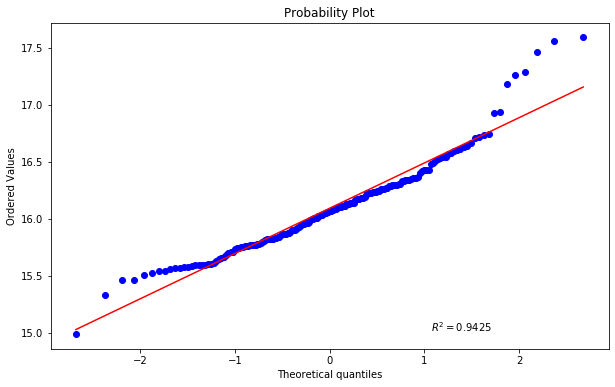

In [253]:
_ = stats.probplot(np.log(daily.volume), dist=stats.norm,  plot=plt, rvalue=True)

# Fitting invgamma

/Users/Andrey/anaconda3/envs/FinEng/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


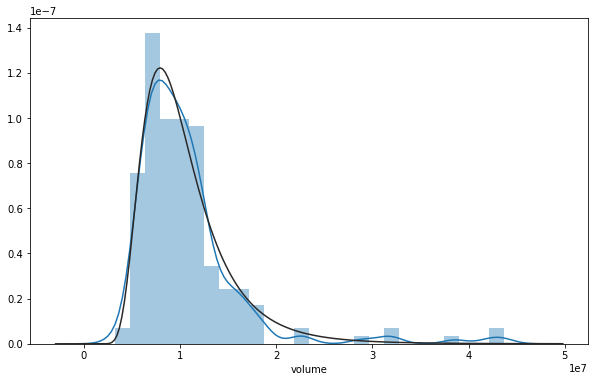

In [254]:
sns.distplot(daily.volume, fit=stats.invgamma)
plt.show()

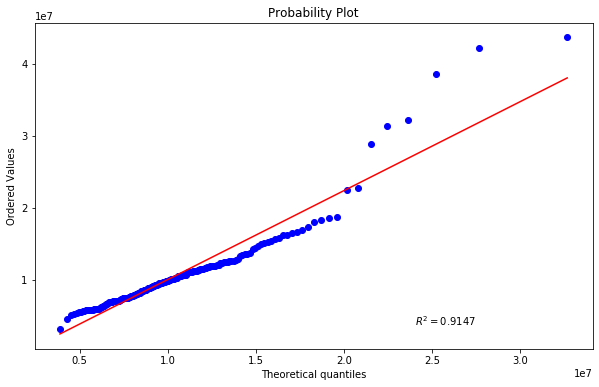

In [255]:
_ = stats.probplot(daily.volume, dist=stats.invgamma, sparams=stats.invgamma.fit(daily.volume), plot=plt, rvalue=True)

# Fitting gamma

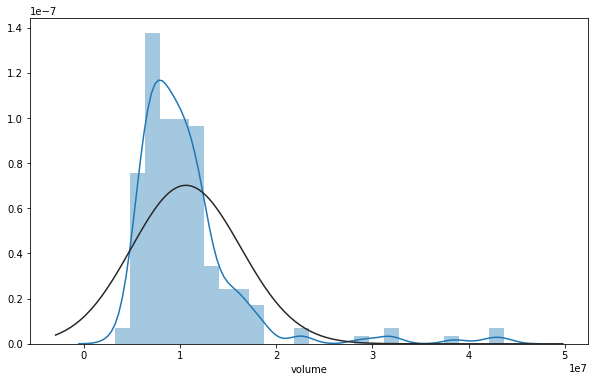

In [256]:
sns.distplot(daily.volume, fit=stats.gamma)
plt.show()

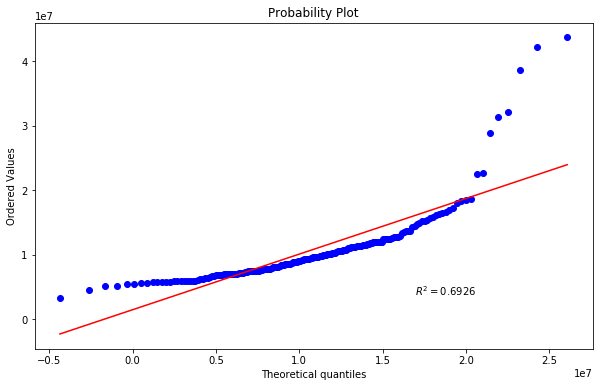

In [257]:
_ = stats.probplot(daily.volume, dist=stats.gamma, sparams=stats.gamma.fit(daily.volume), plot=plt, rvalue=True)

# ARMA for initial daily volume prediction

In [291]:
daily["lv"] = np.log(daily.volume)
daily["mu_lv"] = daily.lv.rolling(rollingWindow).mean()
daily["sigma_lv"] = daily.lv.rolling(rollingWindow).std()
daily["excess_lv"] = daily.lv - daily.mu_lv
daily.tail()

,volume,lv,mu_lv,sigma_lv,excess_lv
date,,,,,
2019-12-23,7330829,15.807599,NaN,NaN,NaN
2019-12-24,3228990,14.987680,NaN,NaN,NaN
2019-12-26,5780968,15.570082,NaN,NaN,NaN
2019-12-27,6958411,15.755462,15.914022,0.425795,-0.158560
2019-12-30,7428730,15.820865,15.926721,0.418624,-0.105856


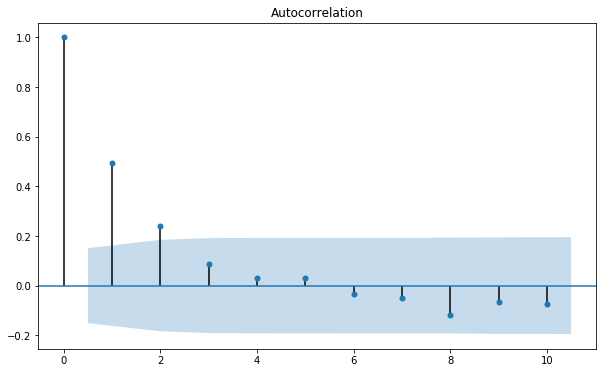

In [259]:
plot_acf(daily.excess_lv.dropna(), lags=10)
plt.show()

In [260]:
model = ARIMA(daily.excess_lv.dropna(), order=(2,0,1))
model_fit = model.fit(trend='nc')
print(model_fit.summary())

/Users/Andrey/anaconda3/envs/FinEng/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:              excess_lv   No. Observations:                  168
Model:                     ARMA(2, 1)   Log Likelihood                 -51.874
Method:                       css-mle   S.D. of innovations              0.328
Date:                Sun, 17 May 2020   AIC                            111.747
Time:                        22:25:28   BIC                            124.243
Sample:                             0   HQIC                           116.819
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ar.L1.excess_lv    -0.4882      0.068     -7.136      0.000      -0.622      -0.354
ar.L2.excess_lv     0.4760      0.069      6.892      0.000       0.341       0.611
ma.L1.excess_lv     1.0000      

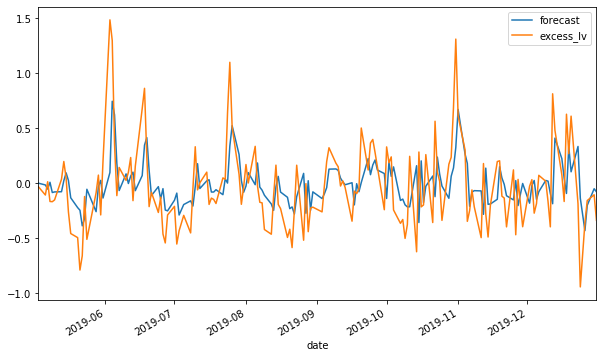

In [261]:
model_fit.plot_predict()
plt.show()

# Intraday volume curve

In [262]:
intraday['raw_vc'] = intraday.loc[:,['date','volume']].groupby('date').apply(lambda x: x / float(x.sum()))
intraday['time'] = intraday.index.time
intraday.tail()

,date,open,close,volume,raw_vc,time
2019-12-31 15:55:00,2019-12-31,205.050,205.32,80138,0.013835,15:55:00
2019-12-31 15:56:00,2019-12-31,205.340,205.13,52535,0.009070,15:56:00
2019-12-31 15:57:00,2019-12-31,205.140,205.16,76489,0.013205,15:57:00
2019-12-31 15:58:00,2019-12-31,205.155,205.15,98079,0.016933,15:58:00
2019-12-31 15:59:00,2019-12-31,205.160,205.09,187882,0.032437,15:59:00


In [263]:
VC = intraday.loc[:,['time','raw_vc']].groupby('time').mean() # average over many days
VC

,raw_vc
time,
09:30:00,0.033069
09:31:00,0.008181
09:32:00,0.007495
09:33:00,0.007200
09:34:00,0.006704
...,...
15:55:00,0.009343
15:56:00,0.006315
15:57:00,0.007135


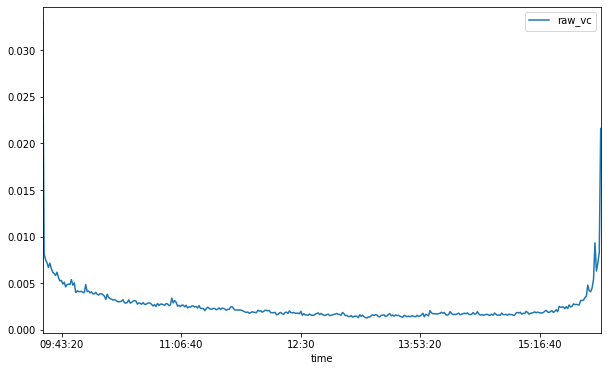

In [264]:
VC.plot()
plt.show()

## Very spiky VC - need to apply smother

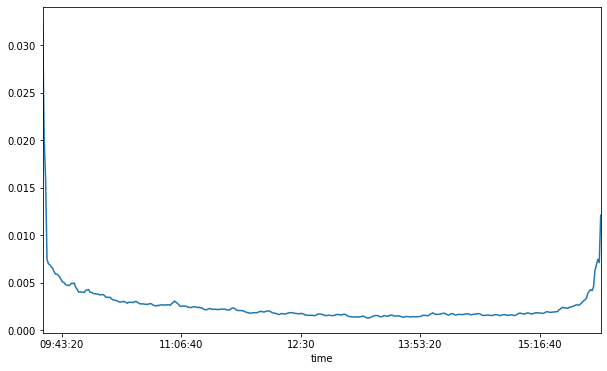

In [265]:
# rolling mean
VC['vc'] = VC.raw_vc.rolling(3, min_periods=1).mean()
VC.vc = VC.vc/VC.vc.sum() # normalize to 1
VC['cumVC'] = VC.vc.cumsum()
VC.vc.plot()
plt.show()

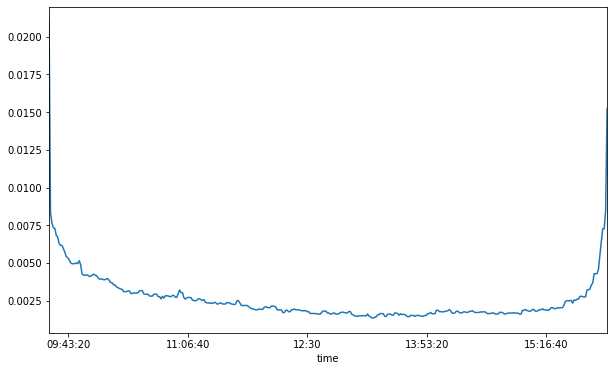

In [266]:
VC['vc'] = VC.raw_vc.rolling(window=3, min_periods=1, center=True).median()
VC.vc = VC.vc/VC.vc.sum() # normalize to 1
VC['cumVC'] = VC.vc.cumsum()
VC.vc.plot()
plt.show()

# Prediction

In [267]:
realized = intraday.where(intraday.date==intraday.date.max()).dropna().reset_index().loc[:,['time','volume']].set_index('time')
realized["cumVolume"] = realized.volume.cumsum()
finalVolume = realized.cumVolume[-1]
realized

,volume,cumVolume
time,,
09:30:00,144900.0,144900.0
09:31:00,27349.0,172249.0
09:32:00,55596.0,227845.0
09:33:00,27339.0,255184.0
09:34:00,39788.0,294972.0
...,...,...
15:55:00,80138.0,5377297.0
15:56:00,52535.0,5429832.0
15:57:00,76489.0,5506321.0


In [268]:
predictedLogExcess = model_fit.forecast()[0]
predictedDailyLV = daily.mu_lv.array[-1] + predictedLogExcess # previous day rolling mean + excess
predictedDailyLV

15.765814346862555

In [269]:
DailyLVvar = daily.lv.rolling(rollingWindow).var()[-1]
DailyLVvar

0.18154505863064693

In [270]:
k0 = 0.5 * rollingWindow

In [271]:
prediction = realized.join(VC)
prediction['x'] = np.log(prediction.volume/prediction.vc)
prediction['n'] = np.arange(1,len(prediction)+1)
prediction['xbar'] = prediction.x.expanding().mean()
prediction['sigma_x'] = prediction.x.expanding().std()
prediction['mu'] = (predictedDailyLV*k0+prediction.n*prediction.xbar)/(k0+prediction.n) # apply 'unknown mean and variance' prediction
prediction['predictedVolume'] = np.ceil(np.exp(prediction.mu))
prediction

,volume,cumVolume,raw_vc,vc,cumVC,x,n,xbar,sigma_x,mu,predictedVolume
time,,,,,,,,,,,
09:30:00,144900.0,144900.0,0.033069,0.021014,0.021014,15.746381,1,15.746381,NaN,15.764048,7018414.0
09:31:00,27349.0,172249.0,0.008181,0.008335,0.029349,15.003682,2,15.375032,0.525168,15.700684,6587497.0
09:32:00,55596.0,227845.0,0.007495,0.007636,0.036985,15.800714,3,15.516926,0.445312,15.708379,6638381.0
09:33:00,27339.0,255184.0,0.007200,0.007335,0.044321,15.131104,4,15.420470,0.411602,15.667145,6370221.0
09:34:00,39788.0,294972.0,0.006704,0.007296,0.051616,15.511790,5,15.438734,0.358790,15.656788,6304585.0
...,...,...,...,...,...,...,...,...,...,...,...
15:55:00,80138.0,5377297.0,0.009343,0.006434,0.961758,16.337610,386,15.339902,0.573178,15.350657,4642008.0
15:56:00,52535.0,5429832.0,0.006315,0.007269,0.969028,15.793305,387,15.341074,0.572899,15.351772,4647187.0
15:57:00,76489.0,5506321.0,0.007135,0.007269,0.976297,16.168972,388,15.343207,0.573700,15.353826,4656738.0


In [272]:
# apply 'unknown mean, known variance' prediction
prediction.loc[prediction.n>100, 'mu'] = (prediction.n*prediction.xbar/np.power(prediction.sigma_x,2) + \
    predictedDailyLV/DailyLVvar)/(prediction.n/np.power(prediction.sigma_x,2) + 2/DailyLVvar)
prediction

,volume,cumVolume,raw_vc,vc,cumVC,x,n,xbar,sigma_x,mu,predictedVolume
time,,,,,,,,,,,
09:30:00,144900.0,144900.0,0.033069,0.021014,0.021014,15.746381,1,15.746381,NaN,15.764048,7018414.0
09:31:00,27349.0,172249.0,0.008181,0.008335,0.029349,15.003682,2,15.375032,0.525168,15.700684,6587497.0
09:32:00,55596.0,227845.0,0.007495,0.007636,0.036985,15.800714,3,15.516926,0.445312,15.708379,6638381.0
09:33:00,27339.0,255184.0,0.007200,0.007335,0.044321,15.131104,4,15.420470,0.411602,15.667145,6370221.0
09:34:00,39788.0,294972.0,0.006704,0.007296,0.051616,15.511790,5,15.438734,0.358790,15.656788,6304585.0
...,...,...,...,...,...,...,...,...,...,...,...
15:55:00,80138.0,5377297.0,0.009343,0.006434,0.961758,16.337610,386,15.339902,0.573178,15.270632,4642008.0
15:56:00,52535.0,5429832.0,0.006315,0.007269,0.969028,15.793305,387,15.341074,0.572899,15.272036,4647187.0
15:57:00,76489.0,5506321.0,0.007135,0.007269,0.976297,16.168972,388,15.343207,0.573700,15.274136,4656738.0


[]

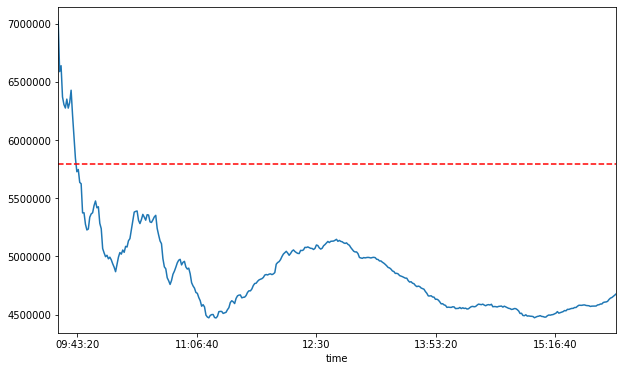

In [273]:
prediction.predictedVolume.plot()
plt.axhline(y=finalVolume, c='red', ls='--')
plt.plot()

In [279]:
PERF = prediction.loc[:,['predictedVolume']]
PERF['elpv'] = np.log(PERF.predictedVolume)-np.log(finalVolume)
PERF['SE'] = np.power(PERF.predictedVolume - finalVolume, 2)
PERF['w'] = PERF.elpv.apply(lambda x: 2 if x>0 else 1)
PERF['LE'] = PERF.w*PERF.elpv.abs()
PERF

,predictedVolume,elpv,SE,w,LE
time,,,,,
09:30:00,7018414.0,0.192011,1.503400e+12,2,0.384022
09:31:00,6587497.0,0.128647,6.323669e+11,2,0.257294
09:32:00,6638381.0,0.136342,7.158835e+11,2,0.272684
09:33:00,6370221.0,0.095108,3.340135e+11,2,0.190216
09:34:00,6304585.0,0.084751,2.624544e+11,2,0.169502
...,...,...,...,...,...
15:55:00,4642008.0,-0.221379,1.323130e+12,1,0.221379
15:56:00,4647187.0,-0.220264,1.311243e+12,1,0.220264
15:57:00,4656738.0,-0.218211,1.289460e+12,1,0.218211


In [280]:
# RMSE
np.sqrt(PERF.SE.sum()/len(PERF))

1001294.6815680969

In [281]:
# ALE
PERF.LE.sum()

72.32736778264801

# Comparison with naive gmean

In [282]:
# RMSE
np.abs(finalVolume - daily.gmav[-1])

2332036.0

In [284]:
# ALE
d = np.log(daily.gmav[-2]) - np.log(finalVolume)
w = 2 if d>0 else 1
len(PERF)*w*np.abs(d)

276.6539432038714

# Forecasting performance

For each date:
- IG 
 - obtain trailing 21-day avg volume for each minute
 - obtain trailing 21-day var volume for each minute
 - obtain daily volume for previous 21 day, compute avg and var
 - compute {$\alpha_t$}
 - obtain the current day's realized volume for each minute
 - for each minute compute forecasted daily volume and forecast error
 - calculate RMSE for the date
 
- LN 
 - obtain daily volume for previous 21 day, compute avg and var
 - train ARMA, predict initial daily volume
 - for each minute compute avg percentage of daily volume, smooth and normalize
 - obtain the current day's realized volume for each minute
 - for each minute compute forecasted daily volume and forecast error
 - calculate RMSE for the date

In [138]:
def get_vc(minutelyVolume, ndays=21):
    """
    Parameters: 
    minutelyVolume (DataFrame): minutely volume indexed by datetime, expected columns: date, volume
    ndays (int): window width in days
  
    Returns: 
    DataFrame: smoothed volume curve (percentage of daily volume) indexed by time
    """
    assert minutelyVolume.date.nunique() == ndays, f"Number of days should be {ndays}, got {minutelyVolume.date.nunique()}"
    minutelyVolume = minutelyVolume.loc[:,['date', 'volume']].copy()
    minutelyVolume['raw_vc'] = minutelyVolume.loc[:,['date','volume']].groupby('date').apply(lambda x: x / float(x.sum()))
    minutelyVolume['time'] = minutelyVolume.index.time
    
    VC = minutelyVolume.loc[:,['time','raw_vc']].groupby('time').mean() # average over days
    VC['vc'] = VC.raw_vc.rolling(window=3, min_periods=1).mean() # use rolling avg to smooth
    VC.vc = VC.vc/VC.vc.sum() # normalize to 1
    return VC[['vc']]

In [139]:
def get_daily_volume(minutelyVolume, ndays=21):
    """
    Parameters: 
    minutelyVolume (DataFrame): minutely volume indexed by datetime, expected columns: date, volume
    ndays (int): window width in days
  
    Returns: 
    DataFrame: daily volume indexed by date
    """
    assert minutelyVolume.date.nunique() == ndays, f"Number of days should be {ndays}, got {minutelyVolume.date.nunique()}"
    daily = minutelyVolume.groupby('date').agg({'volume': 'sum'}).copy()
    daily.index = pd.to_datetime(daily.index)
    
    return daily

In [140]:
def get_initial_vorecast(dailyVolume, ndays=21, fn=np.mean):
    assert len(dailyVolume)==ndays, f"Number of days should be {ndays}, got {len(dailyVolume)}"
    return dailyVolume.agg(fn).transform(np.ceil).values[0]

In [167]:
def ALE(forecast, realized):
    """
    Parameters: 
    forecast (Series): prediction of total daily for every minute
    realized (float): realized total daily volume
  
    Returns: 
    DataFrame: daily volume indexed by date
    """
    d = forecast - realized
    w_fn = lambda x: 1 if x<0 else 2
    return np.sum(np.abs(d) * d.apply(w_fn))

In [289]:
dates = np.flip(intraday.date.unique())
k0 = 0.2 * rollingWindow

for i,dt in enumerate(dates[:-rollingWindow-1]):
    df_validate = intraday[intraday.date == dt]
    realized_volume = df_validate.volume.sum()
    realized_log_volume = np.log(realized_volume)
    
    train_start_dt, train_end_dt = dates[[i+rollingWindow+1, i+1]]
    df_train = intraday[intraday.date.between(train_start_dt, train_end_dt)]
    
    vc = get_vc(df_train)
    nMinutes = len(vc)
    
    daily = get_daily_volume(df_train)
    daily_log_volume_var = daily.volume.var()
    
    initial_volume_forecast = get_initial_vorecast(daily)
    initial_log_volume_forecast = np.log(initial_volume_forecast)    
    
    realized = df_validate.reset_index().loc[:,['time','volume']].set_index('time')
    realized = realized.join(vc)
    realized['x'] = np.log(realized.volume/realized.vc)
    realized['n'] = np.arange(1,len(realized)+1)
    realized['xbar'] = realized.x.expanding().mean()
    realized['mu'] = (initial_log_volume_forecast*k0+realized.n*realized.xbar)/(k0+realized.n) 
    realized['predictedVolume'] = np.ceil(np.exp(realized.mu))
    
    realized['mu2'] = realized['mu']
    realized['sigma_x'] = realized.x.expanding().std()    
    realized.loc[realized.n>100, 'mu2'] = (realized.n*realized.xbar/np.power(realized.sigma_x,2) + \
        initial_log_volume_forecast/daily_log_volume_var)/(realized.n/np.power(realized.sigma_x,2) + 2/daily_log_volume_var)
    realized['predictedVolume2'] = np.ceil(np.exp(realized.mu2))
    
    print(ALE(np.log(realized.predictedVolume), realized_log_volume))
    print(ALE(np.log(realized.predictedVolume2), realized_log_volume))
    print(ALE(pd.Series(np.repeat(initial_log_volume_forecast, nMinutes)), realized_log_volume))
    break

72.08263493232143
75.36509740329728
329.3193318659596
